In [1]:
# Hobo Temperature Sensor Analysis - Cold Storage/Freezer System
# Analysis of temperature data from a freezer with setpoint of -32°F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Hobo Temperature Sensor Data Analysis")
print("=====================================")
print("System: Cold Storage/Freezer")
print("Setpoint: -32°F (-35.6°C)")
print("Analysis Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print()

Hobo Temperature Sensor Data Analysis
System: Cold Storage/Freezer
Setpoint: -32°F (-35.6°C)
Analysis Date: 2025-08-24 20:03:28



In [6]:
## 1. DATA LOADING AND CLEANING

def load_hobo_data(filename):
    """Load hobo temperature data from Excel file"""
    try:
        # Load the main data sheet
        df = pd.read_excel(filename, sheet_name='Data')
        
        # Load events and details if available
        events_df = None
        details_df = None
        
        try:
            events_df = pd.read_excel(filename, sheet_name='Events')
            print("Events sheet loaded successfully")
        except:
            print("No events sheet found or unable to load")
            
        try:
            details_df = pd.read_excel(filename, sheet_name='Details')
            print("Details sheet loaded successfully")
        except:
            print("No details sheet found or unable to load")
        
        return df, events_df, details_df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def clean_temperature_data(df):
    """Clean and prepare temperature data for analysis"""
    # Make a copy
    df_clean = df.copy()
    
    # Rename columns for easier handling
    df_clean.columns = ['Index', 'DateTime', 'Temperature_C']
    
    # Convert datetime
    df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'])
    
    # Convert temperature to numeric and remove any invalid values
    df_clean['Temperature_C'] = pd.to_numeric(df_clean['Temperature_C'], errors='coerce')
    
    # Convert to Fahrenheit
    df_clean['Temperature_F'] = df_clean['Temperature_C'] * 9/5 + 32
    
    # Remove any rows with missing data
    df_clean = df_clean.dropna()
    
    # Sort by datetime
    df_clean = df_clean.sort_values('DateTime').reset_index(drop=True)
    
    # Calculate time differences for sampling rate analysis
    df_clean['TimeDiff'] = df_clean['DateTime'].diff().dt.total_seconds()
    
    print(f"Data cleaned: {len(df_clean)} valid data points")
    print(f"Date range: {df_clean['DateTime'].min()} to {df_clean['DateTime'].max()}")
    print(f"Temperature range: {df_clean['Temperature_F'].min():.1f}°F to {df_clean['Temperature_F'].max():.1f}°F")
    print(f"Average sampling interval: {df_clean['TimeDiff'].median():.0f} seconds")
    
    return df_clean

# Load the data
print("Loading data...")
df_raw, events_df, details_df = load_hobo_data('../data/hobo/22278544 2025-08-15 11_28_32 PDT Freezer.xlsx')

if df_raw is not None:
    print(f"Raw data shape: {df_raw.shape}")
    print(f"Raw data columns: {df_raw.columns.tolist()}")
    
    # Clean the data
    df = clean_temperature_data(df_raw)
    
    print(f"\nCleaned data shape: {df.shape}")
else:
    print("Failed to load data")


Loading data...
Events sheet loaded successfully
Details sheet loaded successfully
Raw data shape: (80620, 3)
Raw data columns: ['#', 'Date-Time (PDT)', 'Temperature , °C']
Data cleaned: 80620 valid data points
Date range: 2025-06-20 11:45:58 to 2025-08-15 11:24:58
Temperature range: -34.7°F to 74.0°F
Average sampling interval: 60 seconds

Cleaned data shape: (80620, 5)


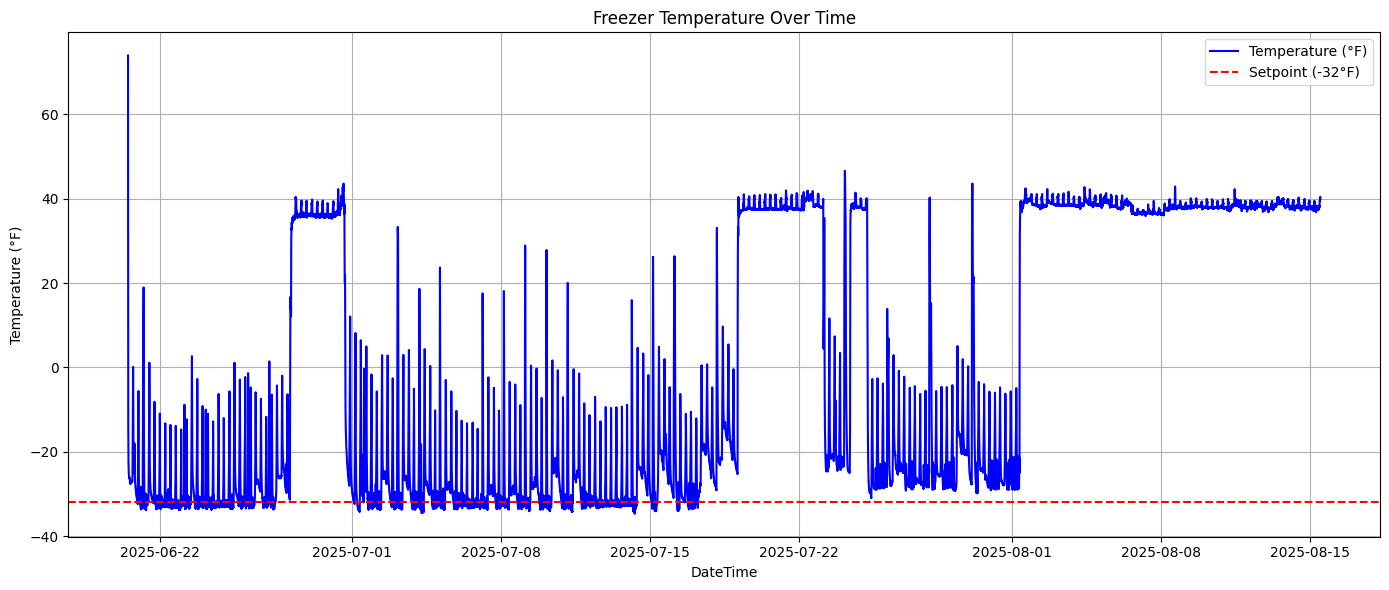

In [7]:
# Make a plot of the raw temperature data for exploratory analysis
plt.figure(figsize=(14, 6))
plt.plot(df['DateTime'], df['Temperature_F'], label='Temperature (°F)', color='blue')
plt.axhline(-32, color='red', linestyle='--', label='Setpoint (-32°F)')
plt.title('Freezer Temperature Over Time')
plt.xlabel('DateTime')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
# Subsetset the data for analysis period if needed
start_date = '2025-07-01'
end_date = '2025-07-18'
df_subset = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)].reset_index(drop=True)
print(f"Data subsetted to {start_date} to {end_date}, shape: {df_subset.shape}")


Data subsetted to 2025-07-01 to 2025-07-18, shape: (24480, 5)


In [9]:
## 2. TEMPERATURE METRICS ANALYSIS

def calculate_temperature_metrics(df, setpoint_f=-32):
    """Calculate comprehensive temperature metrics based on freezer setpoint"""
    
    metrics = {}
    
    # Basic statistics
    metrics['setpoint_f'] = setpoint_f
    metrics['setpoint_c'] = (setpoint_f - 32) * 5/9
    metrics['mean_temp_f'] = df['Temperature_F'].mean()
    metrics['mean_temp_c'] = df['Temperature_C'].mean()
    metrics['std_temp_f'] = df['Temperature_F'].std()
    metrics['min_temp_f'] = df['Temperature_F'].min()
    metrics['max_temp_f'] = df['Temperature_F'].max()
    metrics['range_temp_f'] = metrics['max_temp_f'] - metrics['min_temp_f']
    
    # Deviation from setpoint
    df['deviation_f'] = df['Temperature_F'] - setpoint_f
    metrics['mean_deviation_f'] = df['deviation_f'].mean()
    metrics['abs_mean_deviation_f'] = df['deviation_f'].abs().mean()
    metrics['std_deviation_f'] = df['deviation_f'].std()
    
    # Performance metrics
    tolerance = 5  # ±5°F tolerance
    df['within_tolerance'] = abs(df['deviation_f']) <= tolerance
    metrics['percent_within_tolerance'] = (df['within_tolerance'].sum() / len(df)) * 100
    
    # Time above/below setpoint
    df['above_setpoint'] = df['Temperature_F'] > setpoint_f
    df['below_setpoint'] = df['Temperature_F'] < setpoint_f
    metrics['percent_above_setpoint'] = (df['above_setpoint'].sum() / len(df)) * 100
    metrics['percent_below_setpoint'] = (df['below_setpoint'].sum() / len(df)) * 100
    
    # Temperature excursions (significant deviations)
    excursion_threshold = 10  # °F
    df['excursion'] = abs(df['deviation_f']) > excursion_threshold
    metrics['num_excursions'] = df['excursion'].sum()
    metrics['percent_excursions'] = (metrics['num_excursions'] / len(df)) * 100
    
    # Stability metrics (rate of change)
    df['temp_rate'] = df['Temperature_F'].diff() / (df['TimeDiff'] / 60)  # °F per minute
    metrics['max_heating_rate'] = df['temp_rate'].max()
    metrics['max_cooling_rate'] = df['temp_rate'].min()
    metrics['avg_abs_rate'] = df['temp_rate'].abs().mean()
    
    # Time-based analysis
    metrics['total_hours'] = (df['DateTime'].max() - df['DateTime'].min()).total_seconds() / 3600
    metrics['data_points'] = len(df)
    
    return metrics, df

# Calculate metrics
print("\n" + "="*50)
print("TEMPERATURE PERFORMANCE METRICS")
print("="*50)

metrics, df = calculate_temperature_metrics(df_subset, setpoint_f=-32)

print(f"Freezer Setpoint: {metrics['setpoint_f']:.1f}°F ({metrics['setpoint_c']:.1f}°C)")
print(f"Monitoring Period: {metrics['total_hours']:.1f} hours ({metrics['total_hours']/24:.1f} days)")
print(f"Total Data Points: {metrics['data_points']:,}")
print()
print("TEMPERATURE STATISTICS:")
print(f"  Mean Temperature: {metrics['mean_temp_f']:.1f}°F ({metrics['mean_temp_c']:.1f}°C)")
print(f"  Temperature Range: {metrics['min_temp_f']:.1f}°F to {metrics['max_temp_f']:.1f}°F")
print(f"  Standard Deviation: {metrics['std_temp_f']:.2f}°F")
print()
print("SETPOINT PERFORMANCE:")
print(f"  Mean Deviation from Setpoint: {metrics['mean_deviation_f']:.2f}°F")
print(f"  Absolute Mean Deviation: {metrics['abs_mean_deviation_f']:.2f}°F")
print(f"  Time Within ±5°F Tolerance: {metrics['percent_within_tolerance']:.1f}%")
print(f"  Time Above Setpoint: {metrics['percent_above_setpoint']:.1f}%")
print(f"  Time Below Setpoint: {metrics['percent_below_setpoint']:.1f}%")
print()
print("STABILITY METRICS:")
print(f"  Temperature Excursions (>±10°F): {metrics['num_excursions']:,} ({metrics['percent_excursions']:.2f}%)")
print(f"  Maximum Heating Rate: {metrics['max_heating_rate']:.2f}°F/min")
print(f"  Maximum Cooling Rate: {metrics['max_cooling_rate']:.2f}°F/min")
print(f"  Average Rate of Change: {metrics['avg_abs_rate']:.3f}°F/min")



TEMPERATURE PERFORMANCE METRICS
Freezer Setpoint: -32.0°F (-35.6°C)
Monitoring Period: 408.0 hours (17.0 days)
Total Data Points: 24,480

TEMPERATURE STATISTICS:
  Mean Temperature: -26.5°F (-32.5°C)
  Temperature Range: -34.7°F to 33.3°F
  Standard Deviation: 9.19°F

SETPOINT PERFORMANCE:
  Mean Deviation from Setpoint: 5.53°F
  Absolute Mean Deviation: 5.98°F
  Time Within ±5°F Tolerance: 66.1%
  Time Above Setpoint: 72.5%
  Time Below Setpoint: 27.5%

STABILITY METRICS:
  Temperature Excursions (>±10°F): 4,752 (19.41%)
  Maximum Heating Rate: 5.17°F/min
  Maximum Cooling Rate: -2.93°F/min
  Average Rate of Change: 0.275°F/min


In [10]:
## 3. VISUALIZATION FUNCTIONS

def plot_temperature_profile(df, start_date=None, end_date=None, setpoint=-32):
    """Plot temperature profile for specified date range"""
    
    # Filter data by date range if specified
    if start_date or end_date:
        df_plot = df.copy()
        if start_date:
            df_plot = df_plot[df_plot['DateTime'] >= start_date]
        if end_date:
            df_plot = df_plot[df_plot['DateTime'] <= end_date]
        title_suffix = f" ({start_date} to {end_date})" if start_date and end_date else ""
    else:
        df_plot = df
        title_suffix = ""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Main temperature plot
    ax1.plot(df_plot['DateTime'], df_plot['Temperature_F'], 'b-', linewidth=0.8, alpha=0.7)
    ax1.axhline(y=setpoint, color='red', linestyle='--', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax1.axhline(y=setpoint+5, color='orange', linestyle=':', alpha=0.7, label='±5°F Tolerance')
    ax1.axhline(y=setpoint-5, color='orange', linestyle=':', alpha=0.7)
    ax1.fill_between(df_plot['DateTime'], setpoint-5, setpoint+5, alpha=0.2, color='green')
    
    ax1.set_ylabel('Temperature (°F)', fontsize=12)
    ax1.set_title(f'Temperature Profile - Cold Storage/Freezer{title_suffix}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Deviation plot
    deviation = df_plot['Temperature_F'] - setpoint
    colors = ['red' if x > 0 else 'blue' for x in deviation]
    ax2.scatter(df_plot['DateTime'], deviation, c=colors, alpha=0.6, s=1)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=5, color='orange', linestyle=':', alpha=0.7, label='±5°F Tolerance')
    ax2.axhline(y=-5, color='orange', linestyle=':', alpha=0.7)
    ax2.fill_between(df_plot['DateTime'], -5, 5, alpha=0.2, color='green')
    
    ax2.set_xlabel('Date/Time', fontsize=12)
    ax2.set_ylabel('Deviation from Setpoint (°F)', fontsize=12)
    ax2.set_title('Temperature Deviation from Setpoint', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return fig

def plot_temperature_distribution(df, setpoint=-32):
    """Plot temperature distribution and statistics"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Temperature histogram
    ax1.hist(df['Temperature_F'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=setpoint, color='red', linestyle='--', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax1.axvline(x=df['Temperature_F'].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean ({df["Temperature_F"].mean():.1f}°F)')
    ax1.set_xlabel('Temperature (°F)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Temperature Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Deviation histogram
    deviation = df['Temperature_F'] - setpoint
    ax2.hist(deviation, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Setpoint')
    ax2.axvline(x=deviation.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean Dev ({deviation.mean():.1f}°F)')
    ax2.set_xlabel('Deviation from Setpoint (°F)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Deviation Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Box plot
    box_data = [df['Temperature_F'], [setpoint]*len(df)]
    ax3.boxplot(box_data, labels=['Actual Temp', 'Setpoint'])
    ax3.set_ylabel('Temperature (°F)')
    ax3.set_title('Temperature Box Plot')
    ax3.grid(True, alpha=0.3)
    
    # Hourly temperature profile
    df['Hour'] = df['DateTime'].dt.hour
    hourly_stats = df.groupby('Hour')['Temperature_F'].agg(['mean', 'std', 'min', 'max']).reset_index()
    
    ax4.plot(hourly_stats['Hour'], hourly_stats['mean'], 'b-', marker='o', linewidth=2, label='Mean')
    ax4.fill_between(hourly_stats['Hour'], 
                     hourly_stats['mean'] - hourly_stats['std'], 
                     hourly_stats['mean'] + hourly_stats['std'], 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    ax4.axhline(y=setpoint, color='red', linestyle='--', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Temperature (°F)')
    ax4.set_title('Hourly Temperature Profile')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    return fig

def plot_advanced_analysis(df, setpoint=-32):
    """Plot advanced analysis including trends and performance metrics"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Daily temperature statistics
    df['Date'] = df['DateTime'].dt.date
    daily_stats = df.groupby('Date')['Temperature_F'].agg(['mean', 'min', 'max', 'std']).reset_index()
    daily_stats['Date'] = pd.to_datetime(daily_stats['Date'])
    
    ax1.plot(daily_stats['Date'], daily_stats['mean'], 'b-', marker='o', markersize=3, label='Daily Mean')
    ax1.fill_between(daily_stats['Date'], daily_stats['min'], daily_stats['max'], alpha=0.3, color='lightblue', label='Daily Range')
    ax1.axhline(y=setpoint, color='red', linestyle='--', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (°F)')
    ax1.set_title('Daily Temperature Statistics')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Rate of temperature change
    df['temp_rate'] = df['Temperature_F'].diff() / (df['TimeDiff'] / 60)  # °F per minute
    ax2.hist(df['temp_rate'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2, label='No Change')
    ax2.set_xlabel('Temperature Rate of Change (°F/min)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Temperature Rate of Change Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Performance by day of week
    df['DayOfWeek'] = df['DateTime'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_performance = []
    
    for day in day_order:
        day_data = df[df['DayOfWeek'] == day]
        if len(day_data) > 0:
            within_tolerance = abs(day_data['Temperature_F'] - setpoint) <= 5
            performance = (within_tolerance.sum() / len(day_data)) * 100
            weekly_performance.append(performance)
        else:
            weekly_performance.append(0)
    
    bars = ax3.bar(day_order, weekly_performance, color='lightgreen', edgecolor='black')
    ax3.set_ylabel('% Time Within ±5°F Tolerance')
    ax3.set_title('Performance by Day of Week')
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Add percentage labels on bars
    for bar, perf in zip(bars, weekly_performance):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{perf:.1f}%',
                ha='center', va='bottom', fontsize=9)
    
    # Moving average and control limits
    window = 60  # 1-hour moving average (assuming 1-minute data)
    df['temp_ma'] = df['Temperature_F'].rolling(window=window, center=True).mean()
    df['temp_std_ma'] = df['Temperature_F'].rolling(window=window, center=True).std()
    
    # Plot every nth point to reduce clutter
    n = max(1, len(df) // 5000)  # Show at most 5000 points
    plot_df = df.iloc[::n]
    
    ax4.plot(plot_df['DateTime'], plot_df['Temperature_F'], 'lightblue', alpha=0.5, linewidth=0.5, label='Raw Data')
    ax4.plot(plot_df['DateTime'], plot_df['temp_ma'], 'blue', linewidth=2, label=f'{window}-point Moving Avg')
    ax4.axhline(y=setpoint, color='red', linestyle='--', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax4.set_xlabel('Date/Time')
    ax4.set_ylabel('Temperature (°F)')
    ax4.set_title(f'Temperature Trend with {window}-Point Moving Average')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    return fig



GENERATING VISUALIZATIONS
Creating full temperature profile plot...


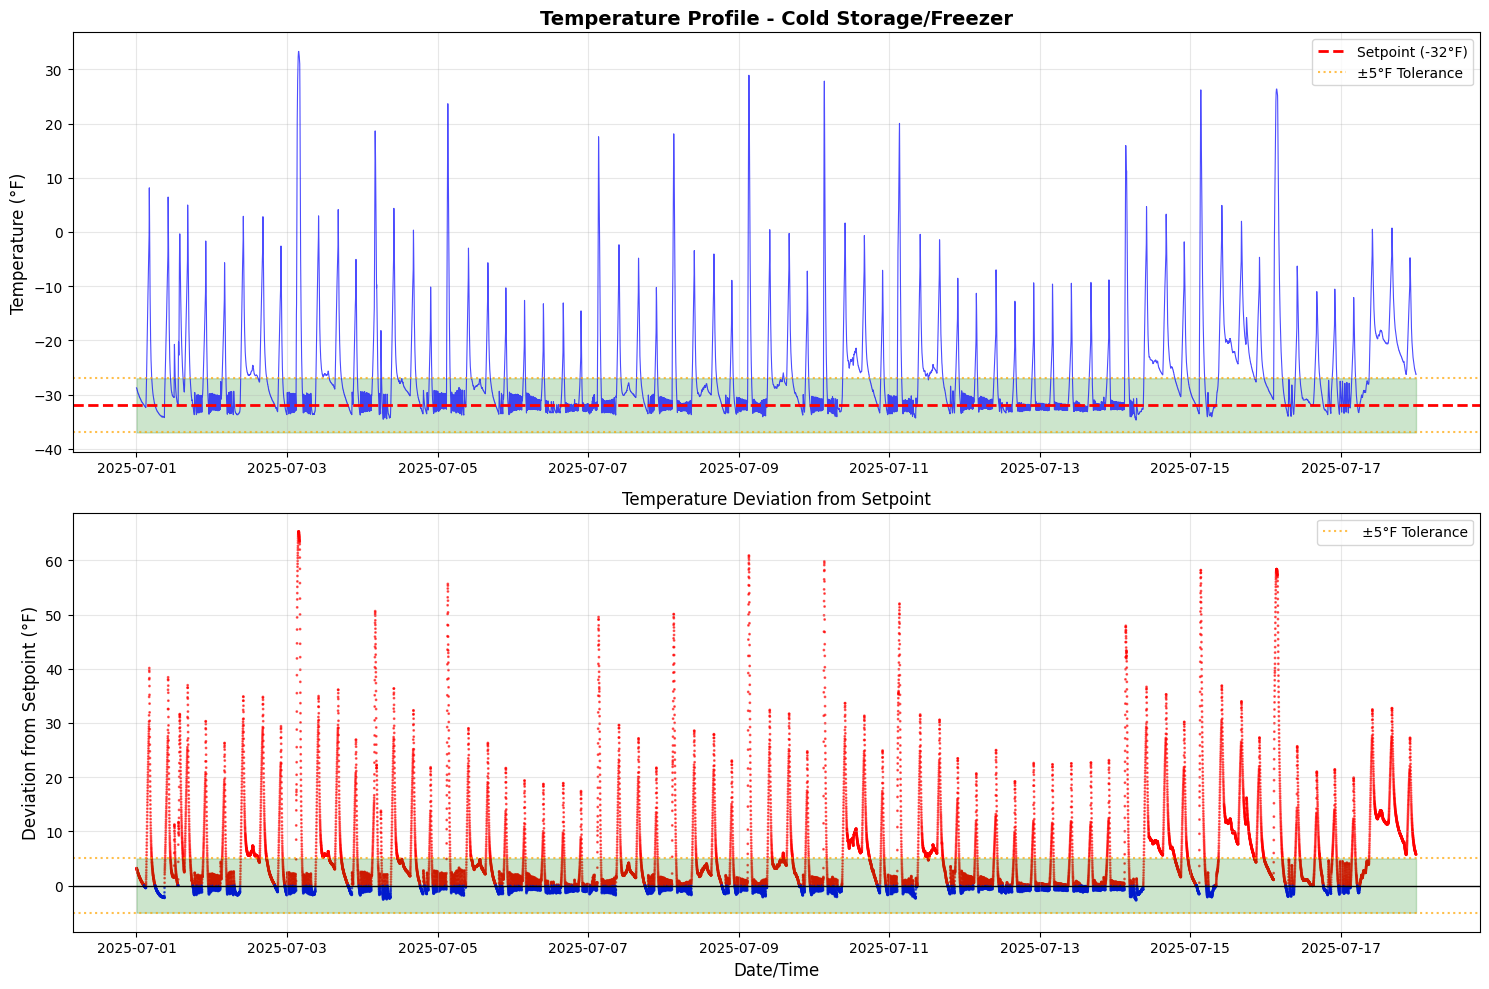

Creating temperature distribution plots...


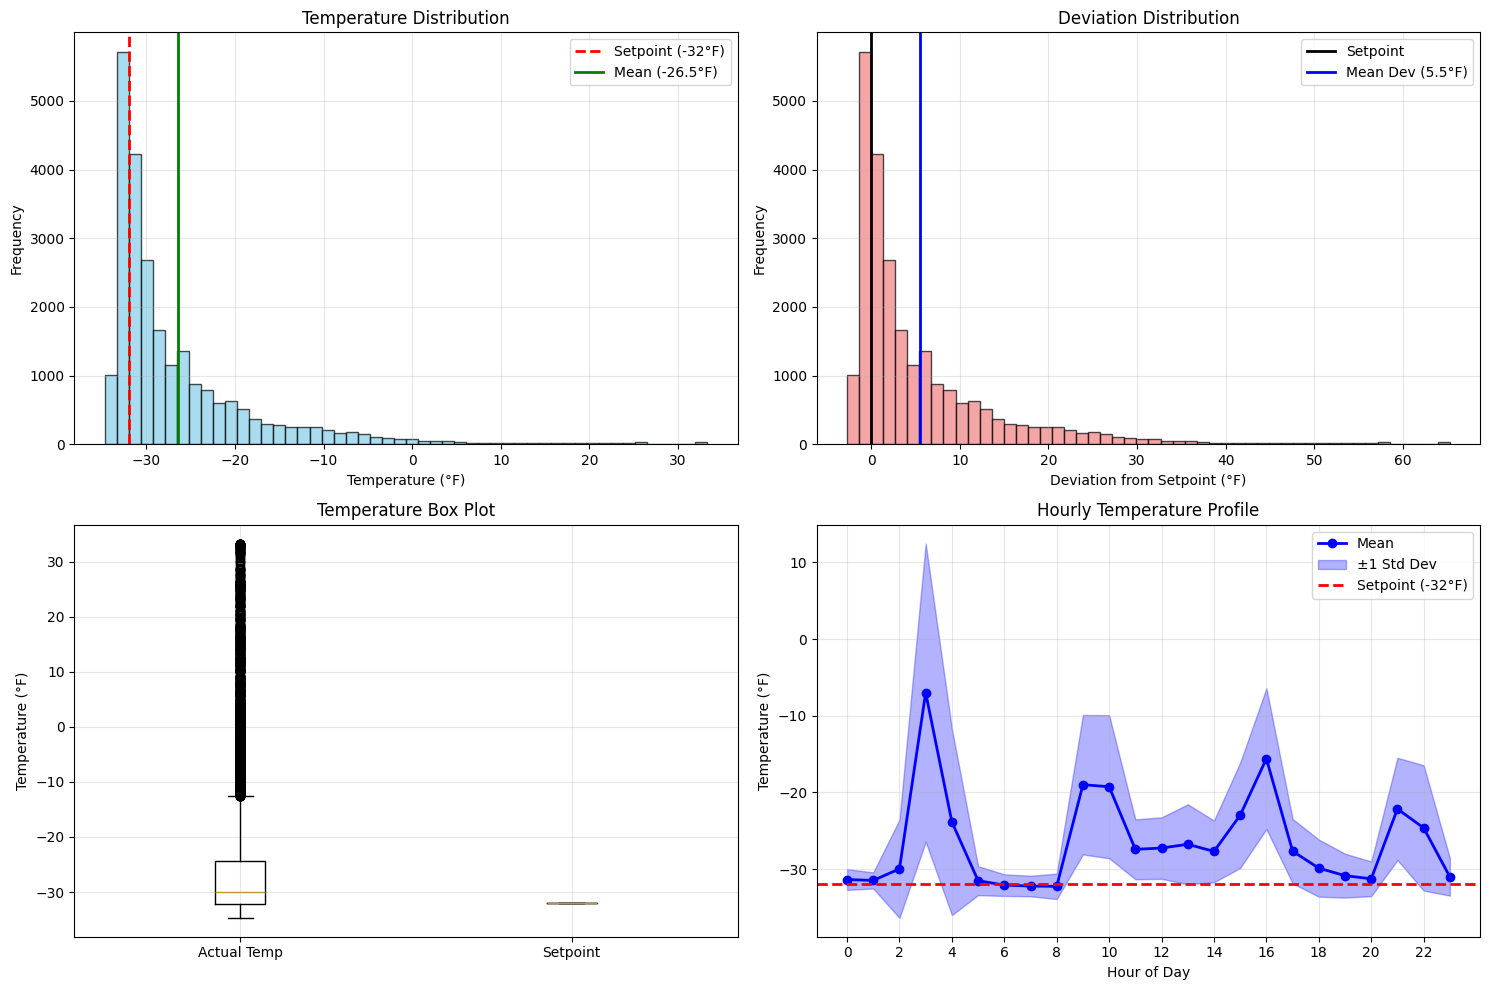

Creating advanced analysis plots...


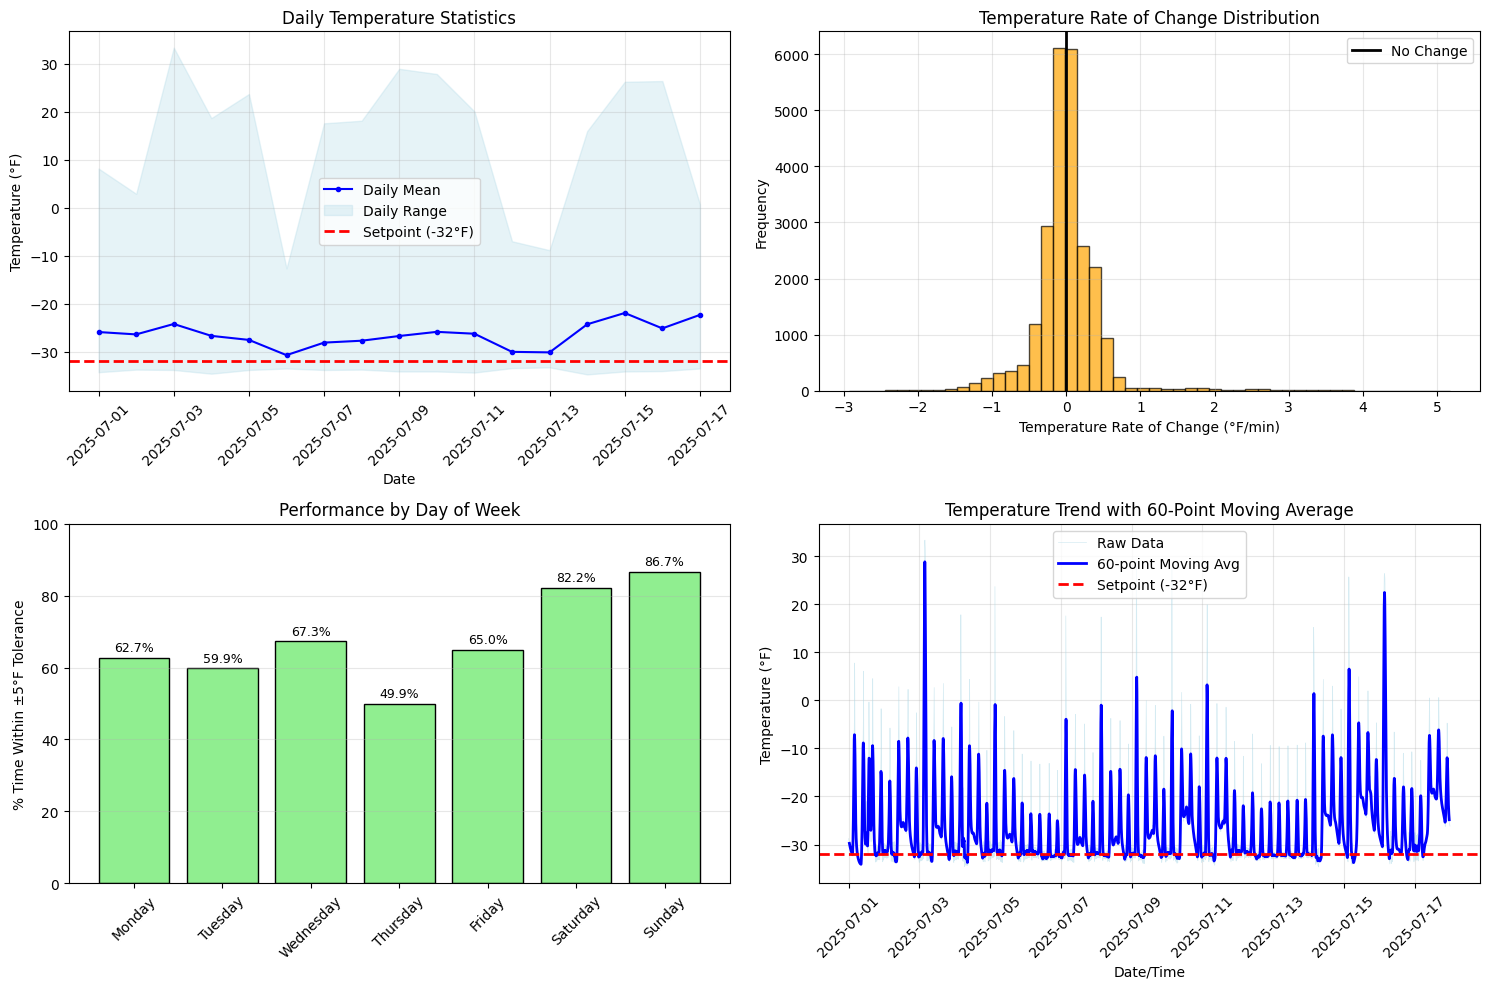

In [11]:
## 4. GENERATE ALL VISUALIZATIONS

print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# Full time series plot
print("Creating full temperature profile plot...")
fig1 = plot_temperature_profile(df_subset, setpoint=-32)
plt.show()

# Temperature distribution analysis
print("Creating temperature distribution plots...")
fig2 = plot_temperature_distribution(df_subset, setpoint=-32)
plt.show()

# Advanced analysis
print("Creating advanced analysis plots...")
fig3 = plot_advanced_analysis(df_subset, setpoint=-32)
plt.show()



DATE RANGE ANALYSIS EXAMPLE
Comparing first week vs last week of data...
First week: 2025-07-01 to 2025-07-08
Last week: 2025-07-10 to 2025-07-17


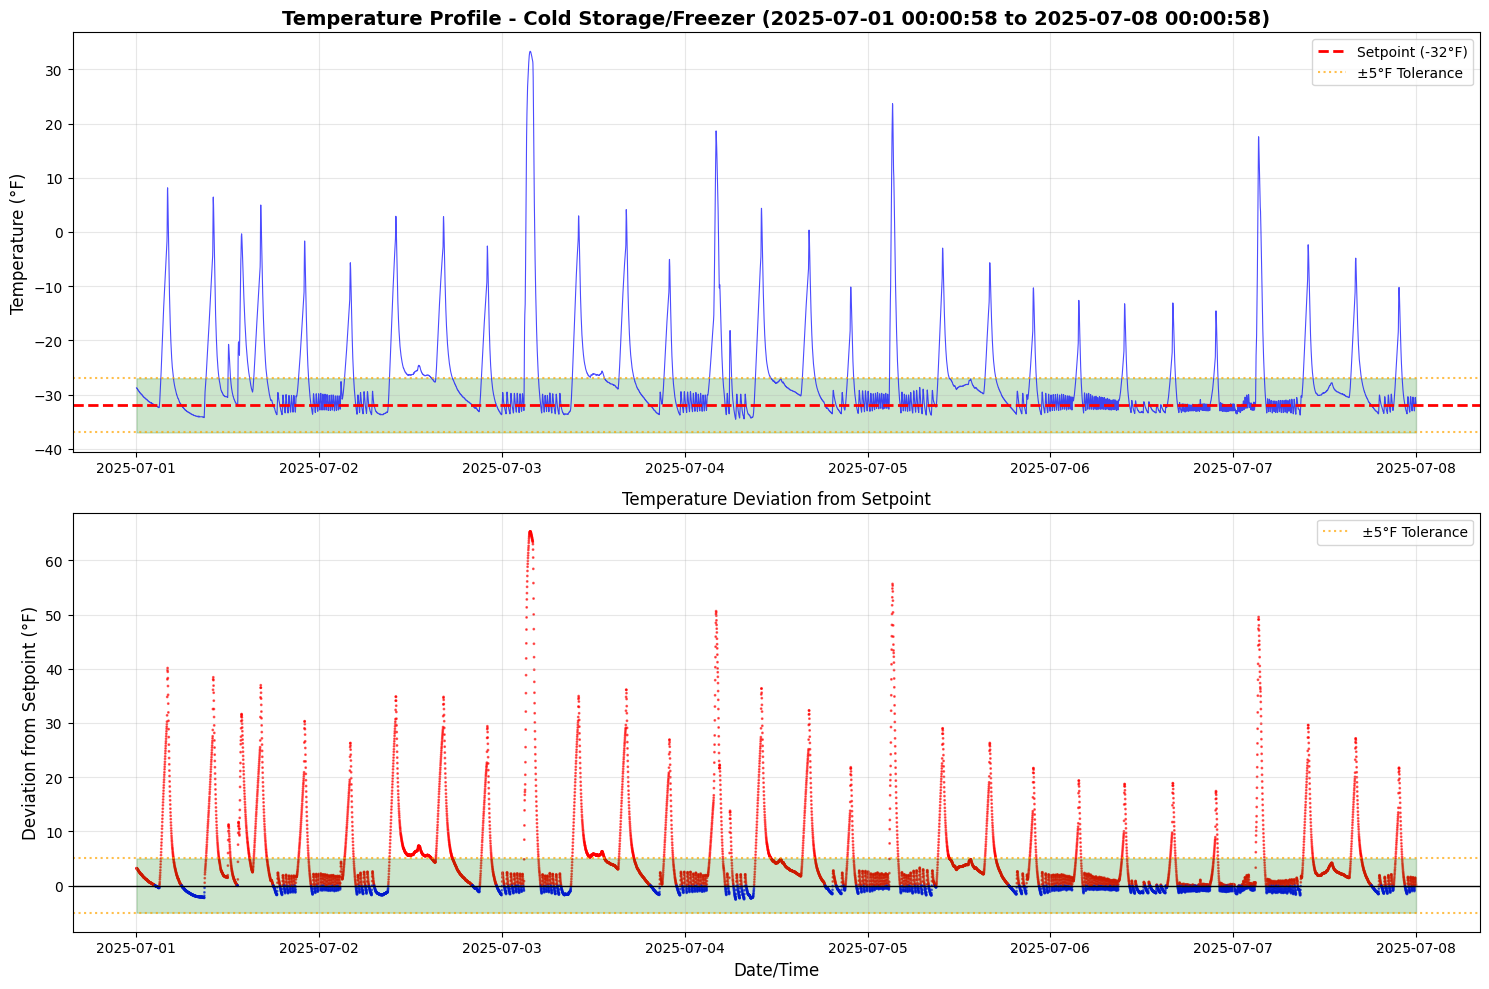

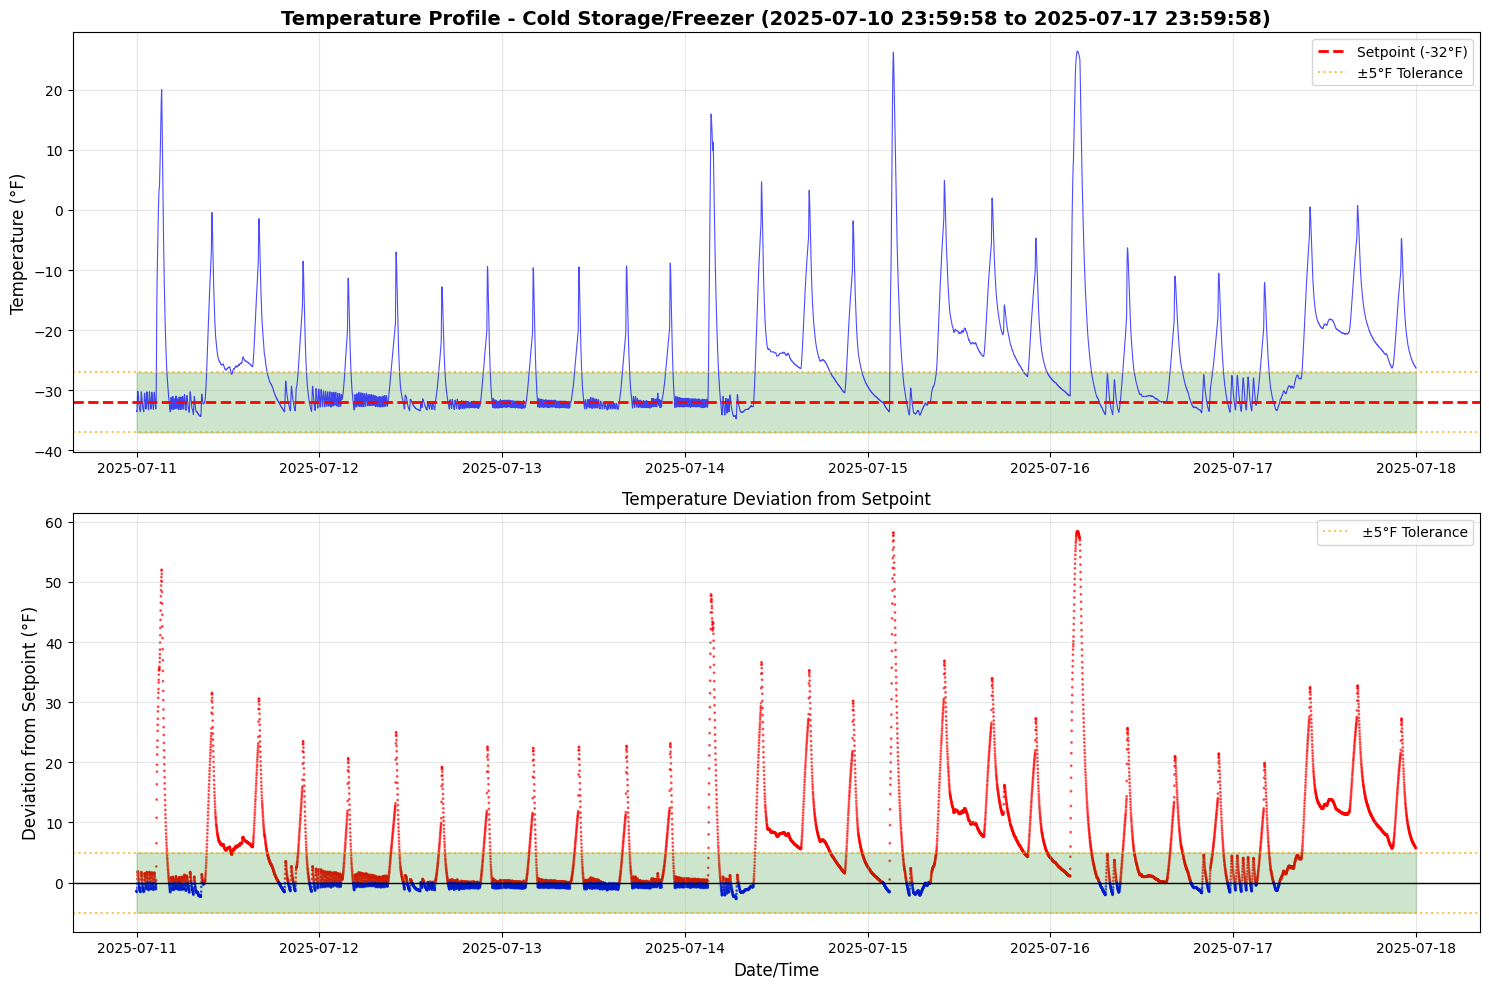

In [12]:
## 5. DATE RANGE ANALYSIS EXAMPLE

# Example: Plot specific date range (adjust dates as needed)
print("\n" + "="*50)
print("DATE RANGE ANALYSIS EXAMPLE")
print("="*50)

# Get first and last week of data for comparison
first_week_end = df['DateTime'].min() + timedelta(days=7)
last_week_start = df['DateTime'].max() - timedelta(days=7)

print("Comparing first week vs last week of data...")
print(f"First week: {df['DateTime'].min().strftime('%Y-%m-%d')} to {first_week_end.strftime('%Y-%m-%d')}")
print(f"Last week: {last_week_start.strftime('%Y-%m-%d')} to {df['DateTime'].max().strftime('%Y-%m-%d')}")

# Plot first week
fig4 = plot_temperature_profile(df, 
                               start_date=df['DateTime'].min(), 
                               end_date=first_week_end, 
                               setpoint=-32)
plt.show()

# Plot last week
fig5 = plot_temperature_profile(df, 
                               start_date=last_week_start, 
                               end_date=df['DateTime'].max(), 
                               setpoint=-32)
plt.show()

In [14]:
## 6. ADDITIONAL ANALYSIS SUGGESTIONS

print("\n" + "="*50)
print("ADDITIONAL ANALYSIS RECOMMENDATIONS")
print("="*50)

print("1. ALARM ANALYSIS:")
print("   - Identify temperature excursions beyond ±10°F")
print("   - Calculate duration and frequency of alarms")
print("   - Correlate with external factors (time of day, day of week)")

print("\n2. ENERGY EFFICIENCY:")
print("   - Analyze compressor cycling patterns")
print("   - Calculate time spent in different temperature zones")
print("   - Identify optimal setpoint for energy savings")

print("\n3. TREND ANALYSIS:")
print("   - Long-term drift in temperature performance")
print("   - Seasonal variations (if data spans multiple seasons)")
print("   - Equipment degradation indicators")

print("\n4. COMPARATIVE ANALYSIS:")
print("   - Compare different operational periods")
print("   - Before/after maintenance comparisons")
print("   - Performance benchmarking against standards")

print("\n5. PREDICTIVE MAINTENANCE:")
print("   - Identify patterns preceding temperature excursions")
print("   - Monitor rate of change as early warning indicator")
print("   - Establish control charts for ongoing monitoring")

## 7. SUMMARY REPORT

print("\n" + "="*60)
print("EXECUTIVE SUMMARY REPORT")
print("="*60)

# Overall system performance grade
if metrics['percent_within_tolerance'] >= 95:
    grade = "EXCELLENT"
    color = "🟢"
elif metrics['percent_within_tolerance'] >= 90:
    grade = "GOOD"
    color = "🟡"
elif metrics['percent_within_tolerance'] >= 85:
    grade = "FAIR"
    color = "🟠"
else:
    grade = "POOR"
    color = "🔴"

print(f"{color} OVERALL SYSTEM PERFORMANCE: {grade}")
print(f"   Temperature Control Accuracy: {metrics['percent_within_tolerance']:.1f}%")
print(f"   Mean Deviation from Setpoint: {metrics['abs_mean_deviation_f']:.2f}°F")

print(f"\n📊 KEY PERFORMANCE INDICATORS:")
print(f"   • Monitoring Period: {metrics['total_hours']/24:.1f} days")
print(f"   • Data Quality: {metrics['data_points']:,} points, ~{metrics['data_points']/(metrics['total_hours']*60):.0f} per hour")
print(f"   • Temperature Stability: {metrics['std_temp_f']:.2f}°F standard deviation")
# print(f"   • Critical Excursions: {metrics['num_excursions']:,} events (>{abs(metrics['setpoint_f'])±10}°F)")

print(f"\n⚠️  AREAS FOR ATTENTION:")
if metrics['percent_within_tolerance'] < 95:
    print(f"   • Control accuracy below target (95%): {metrics['percent_within_tolerance']:.1f}%")
if metrics['abs_mean_deviation_f'] > 3:
    print(f"   • High average deviation: {metrics['abs_mean_deviation_f']:.2f}°F")
if metrics['percent_excursions'] > 1:
    print(f"   • Frequent temperature excursions: {metrics['percent_excursions']:.2f}%")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   • Target: Maintain >95% time within ±5°F of setpoint")
print(f"   • Monitor: Temperature rate of change for early warning")
print(f"   • Review: Equipment performance during identified excursion periods")
print(f"   • Consider: Adjusting control parameters if mean deviation > 2°F")

print(f"\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)


ADDITIONAL ANALYSIS RECOMMENDATIONS
1. ALARM ANALYSIS:
   - Identify temperature excursions beyond ±10°F
   - Calculate duration and frequency of alarms
   - Correlate with external factors (time of day, day of week)

2. ENERGY EFFICIENCY:
   - Analyze compressor cycling patterns
   - Calculate time spent in different temperature zones
   - Identify optimal setpoint for energy savings

3. TREND ANALYSIS:
   - Long-term drift in temperature performance
   - Seasonal variations (if data spans multiple seasons)
   - Equipment degradation indicators

4. COMPARATIVE ANALYSIS:
   - Compare different operational periods
   - Before/after maintenance comparisons
   - Performance benchmarking against standards

5. PREDICTIVE MAINTENANCE:
   - Identify patterns preceding temperature excursions
   - Monitor rate of change as early warning indicator
   - Establish control charts for ongoing monitoring

EXECUTIVE SUMMARY REPORT
🔴 OVERALL SYSTEM PERFORMANCE: POOR
   Temperature Control Accuracy: 66

In [29]:
# Resample data to 5-minute intervals
df_5m = df.resample('5T', on='DateTime').agg({
    'Temperature_C': 'mean'
}).reset_index()

# Fill missing values
df_5m = df_5m.fillna(method='ffill')

# Save the resampled DataFrame to a new CSV file
output_path = os.path.join('~/github/straus-answr/edge/model/training', 'freezer_temperature_resampled.csv')
df_5m.to_csv(output_path, index=False)